# Classification with neural network

## 1. Prepare data

In [1]:


from sklearn.datasets import make_circles

nb_samples=1000

X, y = make_circles(n_samples= nb_samples, noise=0.03, random_state=42)
len(X), len(y)

(1000, 1000)

In [2]:
print(f"First 5 Samples of X:\n {X[:5]}")
print(f"First 5 Samples of y:\n {y[:5]}")

First 5 Samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 Samples of y:
 [1 1 1 1 0]


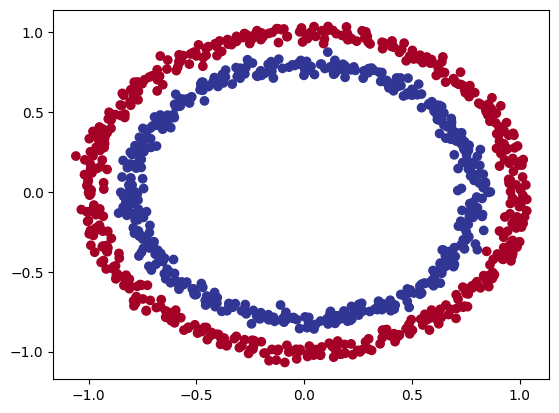

In [3]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

## The goal is to identify if one element is on the blue or red circle

### Shapes of the data set: shows we have 2 inputs and one output

In [4]:

X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# Turn data into tensors and create train and test splits
import torch
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [6]:
# split in training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [7]:
# Build the model: on CPU
from torch import nn

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

'cpu'

#### Create a 5 hidden units in the neuron layer. This amount depends of the dat set. Bigger numbers are good until a certain limit.

In [8]:

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1= nn.Linear(in_features=2, out_features=5)
        self.layer_2= nn.Linear(in_features=5, out_features=1)
        
    def forward(self,x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

see [Tensorflow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.93055&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) to play with Neural Network visually.

#### make prediction on the model

In [11]:
untrained_preds=model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2543],
        [-0.0625],
        [-0.6919],
        [-0.1306],
        [-0.5883],
        [-0.4720],
        [-0.0140],
        [-0.1096],
        [-0.6956],
        [-0.0485]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In previous the label are not the same, and all close to zero. So we need to add loss function and optimizer
To select a loss function looks at the different type in: https://pytorch.org/docs/stable/nn.html#loss-functions

For binary classification we need a loss function for binary selection. The Binary Cross Entropy can be used

In [12]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(params=model_0.parameters(), lr=0.1)


c:\Users\Jerome\Code\ML-studies\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates if two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [14]:
# Training the model
torch.manual_seed(42)
epochs=100
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    # 1. Forward pass (model outputs = raw logits)
    y_logits = model_0(X_train).squeeze() 
    # turn logits -> predicted probabilities -> predicted labels
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.72149, Accuracy: 45.88% | Test loss: 0.72828, Test acc: 44.50
Epoch: 10 | Loss: 0.70220, Accuracy: 43.25% | Test loss: 0.70898, Test acc: 46.50
Epoch: 20 | Loss: 0.69623, Accuracy: 47.50% | Test loss: 0.70208, Test acc: 45.50
Epoch: 30 | Loss: 0.69428, Accuracy: 49.38% | Test loss: 0.69927, Test acc: 45.00
Epoch: 40 | Loss: 0.69361, Accuracy: 50.38% | Test loss: 0.69794, Test acc: 45.50
Epoch: 50 | Loss: 0.69335, Accuracy: 50.75% | Test loss: 0.69722, Test acc: 45.50
Epoch: 60 | Loss: 0.69325, Accuracy: 50.75% | Test loss: 0.69676, Test acc: 47.00
Epoch: 70 | Loss: 0.69319, Accuracy: 50.50% | Test loss: 0.69645, Test acc: 47.50
Epoch: 80 | Loss: 0.69316, Accuracy: 50.88% | Test loss: 0.69621, Test acc: 47.50
Epoch: 90 | Loss: 0.69313, Accuracy: 50.88% | Test loss: 0.69603, Test acc: 47.00


Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.


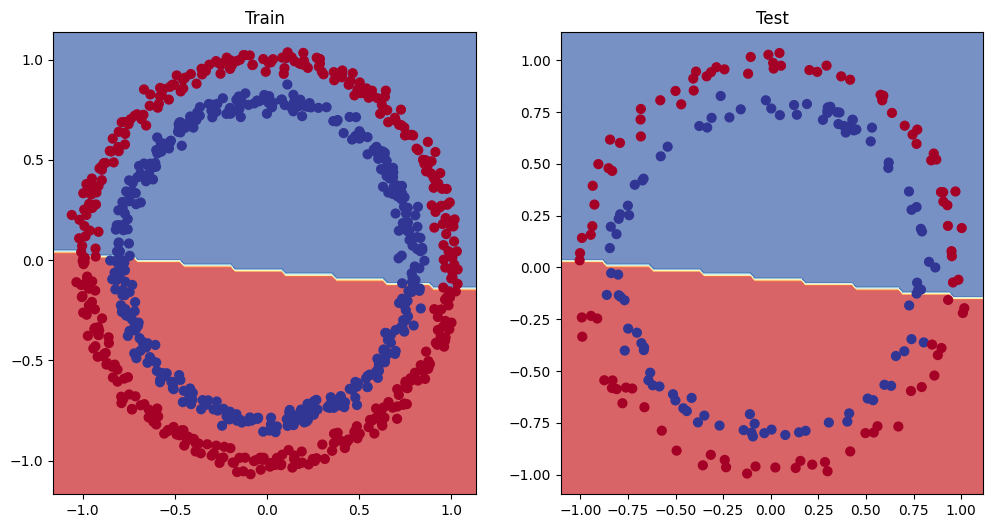

In [16]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

The model is underfitting. Need to improve it. 

# Improve model
Add more layers to the NN, add more features, add ReLU between layers.

In [17]:
class CircleModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1= nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
       
        
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_1 = CircleModel_1().to(device)
model_1


CircleModel_1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [18]:
device

'cpu'

In [19]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(params=model_1.parameters(), lr=0.1)
torch.manual_seed(42)
epochs=100
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
epochs=1000
for epoch in range(epochs):
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69295, Accuracy: 51.00% | Test loss: 0.69319, Test acc: 50.00
Epoch: 10 | Loss: 0.69248, Accuracy: 51.00% | Test loss: 0.69260, Test acc: 50.00
Epoch: 20 | Loss: 0.69225, Accuracy: 51.00% | Test loss: 0.69231, Test acc: 56.50
Epoch: 30 | Loss: 0.69209, Accuracy: 51.00% | Test loss: 0.69212, Test acc: 68.00
Epoch: 40 | Loss: 0.69195, Accuracy: 51.00% | Test loss: 0.69195, Test acc: 71.00
Epoch: 50 | Loss: 0.69181, Accuracy: 51.00% | Test loss: 0.69177, Test acc: 58.00
Epoch: 60 | Loss: 0.69168, Accuracy: 51.00% | Test loss: 0.69161, Test acc: 54.50
Epoch: 70 | Loss: 0.69155, Accuracy: 51.00% | Test loss: 0.69146, Test acc: 53.00
Epoch: 80 | Loss: 0.69141, Accuracy: 51.00% | Test loss: 0.69132, Test acc: 53.00
Epoch: 90 | Loss: 0.69128, Accuracy: 51.00% | Test loss: 0.69117, Test acc: 53.00
Epoch: 100 | Loss: 0.69115, Accuracy: 51.00% | Test loss: 0.69102, Test acc: 52.50
Epoch: 110 | Loss: 0.69103, Accuracy: 51.00% | Test loss: 0.69088, Test acc: 53.50
Epoch: 120 | Lo

In [20]:
# Make predictions
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

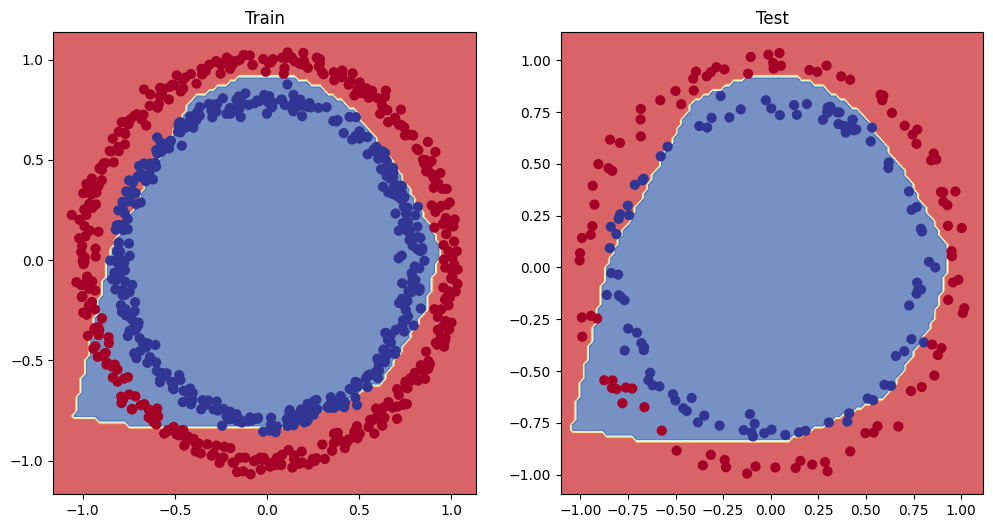

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)